# Table of Contents
* [1. load](#1.-load)
	* [1.1 additional prod batches](#1.1-additional-prod-batches)
	* [1.2 bin accounting](#1.2-bin-accounting)
* [2. build](#2.-build)
	* [run complete build](#run-complete-build)
	* [investigate parsing failures](#investigate-parsing-failures)
	* [2.1 remove missing entities](#2.1-remove-missing-entities)
	* [2.2 write ds json](#2.2-write-ds-json)
* [3. gen segmentation anno data](#3.-gen-segmentation-anno-data)
* [4. clean and spellcheck](#4.-clean-and-spellcheck)
* [5. hide](#5.-hide)


In [2]:
%%capture
from __future__ import division
import numpy as np
import pandas as pd
import scipy.stats as st
import itertools
import math
from collections import Counter, defaultdict
%load_ext autoreload
%autoreload 2

import copy
import os
import json
from tqdm import tqdm
from tqdm import tqdm_notebook

from IPython.display import Image
import PIL.Image as pil
import random
import cv2
import matplotlib as mpl
mpl.use("Agg")
import matplotlib.pylab as plt
#%matplotlib notebook
%matplotlib inline
%load_ext base16_mplrc
%base16_mplrc light solarized
#%base16_mplrc dark solarized
plt.rcParams['grid.linewidth'] = 0
plt.rcParams['figure.figsize'] = (16.0, 10.0)

import anigen_tools
from anigen_tools.dataset import FlintstonesDataset
from anigen_tools.mturk import unpickle_this, pickle_this

import spacy
from nltk.parse.stanford import StanfordParser
from nltk.tokenize import sent_tokenize
from nltk.tree import ParentedTree
from nltk.parse.corenlp import CoreNLPServer
from nltk.parse.corenlp import CoreNLPParser

from anigen_tools.parsing import parse_video

In [3]:
nlp = spacy.load('en')

core_nlp_base = '/Users/schwenk/wrk/animation_gan/phrase_cues/deps/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'
core_parser = CoreNLPParser(url='http://localhost:9000')    

coref_results = unpickle_this('pickled_data/coref_results_full_2.pkl')

In [4]:
def perform_parse(videos, parse_lookup={}, coref_res=coref_results):
    for vid in videos:
        try:
            vid._data['parse'] = parse_lookup[vid.gid()]
            vid.data()['parse']['coref'] = coref_res[vid.gid()]
        except KeyError:
#             print(vid.gid())
            parse_video(vid, nlp, core_parser)
            vid.data()['parse']['coref'] = []

# 1. load

In [5]:
selection_metadata_dir = 'Flintstone_Shots_GIF_Selection'

with open(os.path.join(selection_metadata_dir, 'beta_gif_names.json')) as f:
    beta_videos = json.load(f)
        
with open(os.path.join(selection_metadata_dir, 'production_gif_names.json')) as f:
    production_videos = json.load(f)

initial load

In [6]:
processed_stage_1_a = unpickle_this('./stage_1/pickeled_results/processed_stage1_boxes.pkl')
processed_stage_1_b = unpickle_this('./stage_1/pickeled_results/stage_1b_prod_all_boxes_8_29.pkl')

stage_3a_settings = unpickle_this('stage_3/pickled_data/stage3_prod1_2_settings.pkl')
stage_3b_descriptions =  unpickle_this('stage_3/pickled_data/stage3_prod1_2_descriptions.pkl')

stage_4b_con_boxes = unpickle_this('stage_4/pickled_data/stage_4b_con_batch_2_new_method.pkl')
stage_4a_objects = unpickle_this('stage_4/pickled_data/obj_data.pkl')

In [7]:
processed_stage_1_a_batch_2_3_4 = unpickle_this('./stage_1/pickeled_results/processed_stage1_prod_2_3_4.pkl')
stage_1b_2_3_4 = unpickle_this('./stage_1/pickeled_results/stage_1b_prod_2_3_4.pkl')

stage_3a_settings_2_3_4 = unpickle_this('./stage_3/pickled_data/stage3_prod_2_3_4_settings.pkl')
stage_3b_prod_2_3_4_processed = unpickle_this('./stage_3/pickled_data/stage_3b_prod_2_3_4_processed.pkl')
stage_3b_with_corrections = unpickle_this('./stage_3/pickled_data/corrected_descriptions_with_charnames.pkl')

stage_4a_2_3_4 = unpickle_this('./stage_4/pickled_data/prod_2_3_4_object_hit_res_10_20.pkl')
stage_4b_2_3_4 = unpickle_this('./stage_4/pickled_data/stage_4b_con_batch_2_3_4_latest_10_25.pkl')

update

In [8]:
stage_3b_cleanup_batch_1_10_10_results = unpickle_this('./stage_3/pickled_data/stage_3b_cleanup_batch_1_10_10_processed.pkl')
stage_4a_latest_object_hit_res_10_8 = unpickle_this('./stage_4/pickled_data/latest_object_hit_res_10_8.pkl')
stage_4a_latest_object_hit_res_10_10 = unpickle_this('./stage_4/pickled_data/latest_object_hit_res_10_10.pkl')
stage_4b_con_batch_2_latest_10_9 = unpickle_this('./stage_4/pickled_data/stage_4b_con_batch_2_latest_10_9.pkl')
stage_4b_con_batch_2_latest_10_10 = unpickle_this('./stage_4/pickled_data/stage_4b_con_batch_2_latest_10_10.pkl')

all_stage_3b_descriptions = {**stage_3b_descriptions, **stage_3b_cleanup_batch_1_10_10_results}
all_stage_4a_boxes = {**stage_4a_objects, **stage_4a_latest_object_hit_res_10_8, **stage_4a_latest_object_hit_res_10_10}
all_stage_4b_boxes = {**stage_4b_con_boxes, **stage_4b_con_batch_2_latest_10_9, **stage_4b_con_batch_2_latest_10_10}

In [9]:
all_stage_1a = {**processed_stage_1_a, **processed_stage_1_a_batch_2_3_4}
all_stage_1b = {**processed_stage_1_b, **stage_1b_2_3_4}

all_stage_3a = {**stage_3a_settings, **stage_3a_settings_2_3_4}
all_stage_3b = {**stage_3b_descriptions, **stage_3b_cleanup_batch_1_10_10_results, **stage_3b_prod_2_3_4_processed}

all_stage_4a = {**stage_4a_objects, **stage_4a_latest_object_hit_res_10_8, **stage_4a_latest_object_hit_res_10_10, **stage_4a_2_3_4}
all_stage_4b = {**stage_4b_con_boxes, **stage_4b_con_batch_2_latest_10_9, **stage_4b_con_batch_2_latest_10_10, **stage_4b_2_3_4}

In [10]:
prev_parsed = unpickle_this('./pickled_data/dataset_full26k.pkl')
parse_lookup = {vid.gid(): vid.data()['parse'] for vid in prev_parsed}

## 1.1 additional prod batches

In [11]:
with open('./json_data/ds_production.json') as f:
    prod_vids= json.load(f)
    prod_batch_1_ds = prod_vids[:20000]
    prod_batch_2_ds = prod_vids[20000:30000]
    prod_batch_3_ds = prod_vids[30000:40000]
    prod_batch_4_ds = prod_vids[40000:50000]
    prod_batch_5_ds = prod_vids[50000:]

prod_batch_1 = [vid['globalID'] for vid in prod_batch_1_ds]
prod_batch_2 = [vid['globalID'] for vid in prod_batch_2_ds]
prod_batch_3 = [vid['globalID'] for vid in prod_batch_3_ds]
prod_batch_4 = [vid['globalID'] for vid in prod_batch_4_ds]
prod_batch_5 = [vid['globalID'] for vid in prod_batch_5_ds]
all_prod_batches = [prod_batch_1, prod_batch_2, prod_batch_3, prod_batch_4, prod_batch_5]

In [12]:
prod_dataset_2 = anigen_tools.dataset.FlintstonesDataset(prod_batch_2)
prod_dataset_3 = anigen_tools.dataset.FlintstonesDataset(prod_batch_3)
prod_dataset_4 = anigen_tools.dataset.FlintstonesDataset(prod_batch_4)

In [13]:
prod_dataset_2_3_4 = anigen_tools.dataset.FlintstonesDataset(prod_batch_2 + prod_batch_3 + prod_batch_4)

## 1.2 bin accounting

In [14]:
vid_bins = unpickle_this('./pickled_data/vid_bin_assignments.pkl')
vid_bins_2_3_4 = unpickle_this('../turk_annotation_task/stage_1/pickeled_results/vid_bin_assignments_2_3_4.pkl')
vid_bins_batch_2_3_4 = unpickle_this('../turk_annotation_task/stage_1/pickeled_results/prod_2_3_4_failed_at_s1.pkl')

vid_bin_lookup = {}
for k, vals in list(vid_bins.items()) + list(vid_bins_2_3_4.items()):
    for v in vals:
        vid_bin_lookup[v] = k

In [15]:
pass_bins = set(['bin_01_vids', 'bin_02_vids', 'bin_09_vids', 'bin_10_vids'])

In [16]:
failed_stage_1 = {k: v not in pass_bins for k, v in vid_bin_lookup.items()}

1. #boxes = 3 x # characters detected. Each box has 3 votes. ------- This may also contain an error, but no way to fix this.
2. 1 box lies outside of consensus and it is Empty Frame
3. 2+ boxes lies outside of consensus and they are all Empty Frame
4/5. 1/2+ box lies outside of consensus and all are Main char
6/7. 1/2+ box lies outside of consensus and it all are Other char
8. 2+ box lies outside of consensus and they are a mix of other/main/empty
9: 2+ characters detected, but at least one has < 3: votes
10. Empty frame (consensus)
11. extra annotation

decisions:

Next steps:
1. Pass through 1,2,9,10
2. 11 is easy
3. Spend a few hours for 4,5 and new visualizations for these

Stage 1-b:
1. Videos with all consensus
2/3/4/5/6. Videos with all but 1/2/3/4/5

bin5: cancel/redo

bin6: pass

bin7: cancel/redo

Choose Bins 1,2,4,6,9,10,11

# 2. build

## run complete build

In [17]:
complete_dataset = FlintstonesDataset(prod_batch_1 + prod_batch_2 + prod_batch_3 + prod_batch_4)

complete_dataset.update_s1a(all_stage_1a)
complete_dataset.filter_on_s1_quality(failed_stage_1)
complete_dataset.update_s1b(all_stage_1b)

complete_dataset.update_s3a(all_stage_3a)
complete_dataset.update_s3b(all_stage_3b)
complete_dataset.update_s3b_w_corrections(stage_3b_with_corrections)

complete_dataset.update_s4a(all_stage_4a)
complete_dataset.update_s4b(all_stage_4b)

In [18]:
complete_vids_all = complete_dataset.filter_videos({'stage': 'stage_4b- objects', 'go': True}) + complete_dataset.filter_videos({'stage': 'stage_4b- no objects', 'go': True})

In [19]:
complete_vids_all = complete_vids_all[:500]

In [20]:
from tqdm import tqdm

In [22]:
perform_parse(tqdm(complete_vids_all), {}, coref_results)

100%|██████████| 500/500 [00:23<00:00, 21.34it/s]


In [23]:
_ = [vid.assign_ent_npcs(vid._data['objects'], False) for vid in complete_vids_all]
_ = [vid.assign_ent_npcs(vid._data['characters']) for vid in complete_vids_all]

In [24]:
corrections = spellcheck_dataset(complete_vids_all)

NameError: name 'spellcheck_dataset' is not defined

In [ ]:
final_clean_complete_vids = [vid for vid in complete_vids_all if vid.gid() not in vids_to_remove]
dataset_to_json(final_clean_complete_vids, '3p2')

In [73]:
# complete_dataset.generate_release_version('v2p0')

In [1040]:
# verification_failures = complete_dataset.verify_entities()

In [1039]:
{k: len(v) for k, v in verification_failures.items()}

{'missing entity span': 149,
 'no referring words': 3637,
 'referring word issue': 50}

In [357]:
{k: len(v) for k, v in verification_failures.items()}

{'missing entity span': 208,
 'no referring words': 2797,
 'referring word issue': 12}

In [ ]:
# complete_vids_all = unpickle_this('complete_vids_all.pkl')

In [1842]:
# with open('complete_vids_working_copy_1.pkl', 'wb') as f:
#     pickle.dump(complete_vids_all, f)

# with open('complete_vids_working_copy.pkl', 'rb') as f:
#     complete_vids_chckpt = pickle.load(f)

In [945]:
pickle_this(complete_vids_all, 'ds_v3p0_2.pkl')

## investigate parsing failures 

1. Noun Phrase Chunking misaligned with POS taggs


2. LabelNPC misaligned with POS-Tags using entitySpan indices


3. Referring index empty

s_04_e_16_shot_031729_031803

s_01_e_14_shot_003740_003814

s_03_e_06_shot_008140_008214

s_04_e_22_shot_016852_016926

s_03_e_19_shot_037103_037177

s_02_e_05_shot_011297_011371 no space between sentences

s_02_e_13_shot_010303_010377


s_04_e_22_shot_022212_022286 mislabeled character corrected

s_01_e_15_shot_028356_028430

s_03_e_01_shot_029459_029533

s_02_e_18_shot_030919_030993

s_01_e_14_shot_022575_022649

s_06_e_02_shot_012373_012447

In [2684]:
test_vid = complete_dataset.get_video('s_04_e_10_shot_026510_026584')
test_ent = test_vid.data()['characters'][0]

In [2685]:
test_vid.description()

'Fred and Barney are kneeling on the ground outside a building. Betty is inside the building. She is peeking out through the window. Fred and Barney have their hand to their ear. They are listening for a noise. Then Fred and Barney lower their hands and look at each other. Fred speaks to Barney.'

In [2688]:
vid_text = sanitize_text(doc)
raw_sentences = sentence_splitter.tokenize(vid_text)
sentences = [' '.join([w for w in word_tokenize(s) if set(w) - punct_set]).replace(' .',  '.') for s in raw_sentences]
print(sentences)
# docs = [nlp(sent) for sent in sentences]

# noun_phrase_chunks = {
#     'chunks': [[(np.start, np.end) for np in doc.noun_chunks] for doc in docs],
#     'named_chunks': [[np.text for np in doc.noun_chunks] for doc in docs]
# }
# constituent_parse = const_parse(vid_text, parser)
constituent_parse = [list(i)[0] for i in core_parser.raw_parse_sents(sentences)]

['Fred and Barney are kneeling on the ground outside a building.', 'Betty is inside the building.', 'She is peeking out through the window.', 'Fred and Barney have their hand to their ear.', 'They are listening for a noise.', 'Then Fred and Barney lower their hands and look at each other.', 'Fred speaks to Barney.']


In [2735]:
from anigen_tools.parsing import parse_description

In [2738]:
const_parse = parse_description(test_vid.description(), nlp, core_parser)

Fred and Barney
0 15
('Fred', 0, 4)
0
('and', 5, 8)
('Barney', 9, 15)
('are', 16, 19)
('kneeling', 20, 28)
('on', 29, 31)
('the', 32, 35)
('ground', 36, 42)
('outside', 43, 50)
('a', 51, 52)
('building', 53, 61)
('.', 61, 62)
('Betty', 63, 68)
('is', 69, 71)
('inside', 72, 78)
('the', 79, 82)
('building', 83, 91)
('.', 91, 92)
('She', 93, 96)
('is', 97, 99)
('peeking', 100, 107)
('out', 108, 111)
('through', 112, 119)
('the', 120, 123)
('window', 124, 130)
('.', 130, 131)
('Fred', 0, 4)
0
('and', 5, 8)
('Barney', 9, 15)
('have', 148, 152)
('their', 153, 158)
('hand', 159, 163)
('to', 164, 166)
('their', 167, 172)
('ear', 173, 176)
('.', 176, 177)
('They', 178, 182)
('are', 183, 186)
('listening', 187, 196)
('for', 197, 200)
('a', 201, 202)
('noise', 203, 208)
('.', 208, 209)
('Then', 210, 214)
('Fred', 215, 219)
('and', 220, 223)
('Barney', 224, 230)
('lower', 231, 236)
('their', 237, 242)
('hands', 243, 248)
('and', 249, 252)
('look', 253, 257)
('at', 258, 260)
('each', 261, 265)
('ot

In [ ]:
compute_token_spans()

In [2728]:
# const_parse

In [2711]:
' '.join(sent0.leaves())

'The red-haired businessman , might be accountant is talking on the phone in his office .'

In [2702]:
test_parse = test_vid.data()['parse']

In [2538]:
' '.join([w[0] for w in vid_pos_tags[0][16:18]])

'The pig'

In [2680]:
vid_pos_tags = test_vid.data()['parse']['pos_tags']
vidnpcs = test_vid.data()['parse']['noun_phrase_chunks']

lnpc = test_ent.data()['labelNPC']
# entspan = test_ent.data()['entitySpan']
entlabel = test_ent.data()['entityLabel']
# concat_pos = concat_pos_tags(vid_pos_tags)

In [2663]:
vid_text = sanitize_text(doc)
raw_sentences = sentence_splitter.tokenize(vid_text)
sentences = [' '.join([w for w in wordpunct_tokenize(s) if set(w) - punct_set]).replace(' .',  '.') for s in raw_sentences]

In [2664]:
raw_sentences == sentences

True

In [2658]:
sentences

['Fred and Barney are kneeling on the ground outside a building.',
 'Betty is inside the building.',
 'She is peeking out through the window.',
 'Fred and Barney have their hand to their ear.',
 'They are listening for a noise.',
 'Then Fred and Barney lower their hands and look at each other.',
 'Fred speaks to Barney.']

In [2420]:
# constituent_parse = [list(i)[0] for i in core_parser.raw_parse_sents(raw_sentences)]
# # pos_tags = [sent.pos() for sent in constituent_parse]

In [2477]:
# pos_tags

In [2478]:
test_vid.description()

'The red-haired businessman, might be accountant is talking on the phone in his office.'

In [1945]:
from spacy.tokens import Doc

class WhitespaceTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        words = text.split(' ')
        # All tokens 'own' a subsequent space character in this tokenizer
        spaces = [True] * len(words)
        return Doc(self.vocab, words=words, spaces=spaces)

In [2093]:
nlp = spacy.load('en')
nlp.tokenizer = WhitespaceTokenizer(nlp.vocab)

In [2479]:
# doc = test_vid.description()

# spacy_doc = nlp(sanitize_text(doc))
# spacy_pos_tags = [(token.text, token.pos_, token.string) for token in spacy_doc]

In [2100]:
# list(spacy_doc.)

[A man with hat, white bowtie and blue shirt is talking in a room.]

In [2480]:
# [np.text for np in doc.noun_chunks] 

In [2681]:
def are_coref_pos_misaligned(npcs, sent_pos_tags_concat):
    for sentn in range(len(sent_pos_tags_concat)):
        pos_tags_concat = sent_pos_tags_concat[sent_n]
        for (chunk,chunk_name) in zip(npcs['chunks'][sent_n], npcs['named_chunks'][sent_n]):
#             print(chunk_name)
            s,e = chunk
            if e > len(pos_tags_concat):
                return True
            chunk_name_recon = ' '.join([pos_tags_concat[i][0] for i in range(s,e)])
            if chunk_name_recon.lower() != chunk_name.lower():
                print(chunk_name_recon + ' : ' + chunk_name)
                return True
    return False

In [2682]:
vidnpcs

{'chunks': [[[0, 1], [3, 6], [8, 10], [12, 14], [15, 16], [16, 18]]],
 'named_chunks': [['Barney',
   'the dining room',
   'an apple',
   'a pig',
   'mouth',
   'The pig']]}

In [2683]:
are_coref_pos_misaligned(vidnpcs, vid_pos_tags)

False

In [2101]:
onstituent_parse = const_parse(vid_text, parser)

In [1817]:
test_vid_exp = deepcopy(test_vid)

In [1778]:
def are_entity_pos_misaligned(entity_npc,entity_span,pos_tags_concat):
    s,e = entity_span
    if e>len(pos_tags_concat):
        return True

    entity_name_recon_set = set(
        [pos_tags_concat[i][0].lower() for i in range(s,e)])
    entity_npc_set = set(entity_npc.lower().split(' '))
    if len(entity_npc_set & entity_name_recon_set)==0:
        print(f'{entity_name_recon_set} : {entity_npc_set}')
        return True

#     print(f'{entity_name_recon_set} : {entity_npc_set}')
    return False

In [1779]:
are_entity_pos_misaligned(lnpc, entspan, vid_pos_tags)

set() : {'fred'}


True

In [1686]:
spacy_doc[11:12]

room

In [1591]:
[vid_pos_tags[i][0].lower() for i in range(*entspan)]

['in']

In [1690]:
vidnpcs

{'chunks': [(0, 4), (7, 9), (10, 12), (13, 14), (17, 19), (20, 21)],
 'named_chunks': ['A white haired woman',
  'a table',
  'a room',
  'Wilma',
  'the room',
  'They']}

In [1674]:
idx = 5
print(vidnpcs['chunks'][idx])
print(vidnpcs['named_chunks'][idx])

(20, 21)
They


In [1622]:
doc = nlp(test_vid.description())

In [1623]:
doc[11:12]

in

In [2144]:
test_vid = complete_dataset.get_video('s_01_e_15_shot_028356_028430')

In [2150]:
test_vid.description()

'The red-haired businessman, might be accountant is talking on the phone in his office.'

In [2550]:
doc = test_vid.description()

In [2614]:
raw_sentences = sentence_splitter.tokenize(doc)
sentences = [' '.join([w for w in word_tokenize(s) if set(w) - punct_set]).replace(' .', '.') for s in raw_sentences]
# sent_parses = [list(i)[0] for i in core_parser.raw_parse_sents(sentences)]
constituent_parse = [list(i)[0] for i in core_parser.raw_parse_sents(sentences)]

In [2616]:
    print([s.leaves() for s in constituent_parse])

[['Fred', 'and', 'Barney', 'are', 'kneeling', 'on', 'the', 'ground', 'outside', 'a', 'building', '.'], ['Betty', 'is', 'inside', 'the', 'building', '.'], ['She', 'is', 'peeking', 'out', 'through', 'the', 'window', '.'], ['Fred', 'and', 'Barney', 'have', 'their', 'hand', 'to', 'their', 'ear', '.'], ['They', 'are', 'listening', 'for', 'a', 'noise', '.'], ['Then', 'Fred', 'and', 'Barney', 'lower', 'their', 'hands', 'and', 'look', 'at', 'each', 'other', '.'], ['Fred', 'speaks', 'to', 'Barney', '.']]


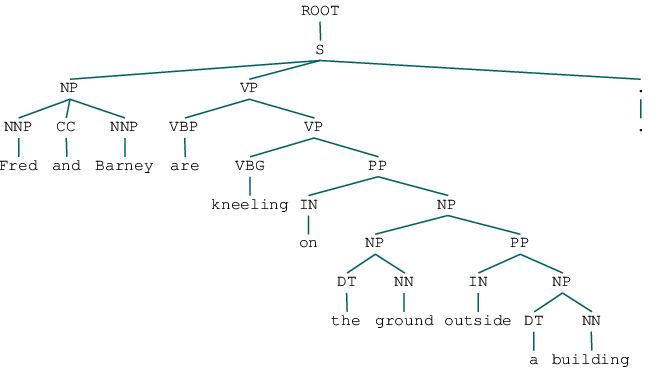

In [2615]:
constituent_parse[0]

In [2590]:
sentences

['Fred and Barney are kneeling on the ground outside a building.',
 'Betty is inside the building.',
 'She is peeking out through the window.',
 'Fred and Barney have their hand to their ear.',
 'They are listening for a noise.',
 'Then Fred and Barney lower their hands and look at each other.',
 'Fred speaks to Barney.']

In [2602]:
np_chunker(doc, sent_parses)

[['Fred and Barney', 'the ground', 'a building'], ['Betty', 'the building'], ['the window'], ['Fred and Barney', 'their hand', 'their ear'], ['a noise'], ['Fred and Barney'], ['Fred', 'Barney']]
Fred and Barney
the ground
a building
Betty
the building
the window
Fred and Barney
their hand
their ear
a noise
Fred and Barney
failed
Fred
Barney
failed


{'chunks': [[[0, 3], [6, 8], [9, 11]],
  [[0, 1], [3, 5]],
  [[5, 7]],
  [[0, 3], [4, 6], [7, 9]],
  [[4, 6]],
  [],
  [[0, 1]]],
 'named_chunks': [['Fred and Barney', 'the ground', 'a building'],
  ['Betty', 'the building'],
  ['the window'],
  ['Fred and Barney', 'their hand', 'their ear'],
  ['a noise'],
  ['Fred and Barney'],
  ['Fred', 'Barney']]}

In [2598]:
from anigen_tools.parsing import extract_np
from anigen_tools.parsing import np_chunker

In [2564]:
 noun_phrases = [list(extract_np(sent)) for sent in sent_parses]

In [2566]:
noun_phrases

[['Fred and Barney', 'the ground', 'a building'],
 ['Betty', 'the building'],
 ['the window'],
 ['Fred and Barney', 'their hand', 'their ear'],
 ['a noise'],
 ['Fred and Barney'],
 ['Fred', 'Barney']]

In [2569]:
raw_sentences

['Fred and Barney are kneeling on the ground outside a building.',
 'Betty is inside the building.',
 'She is peeking out through the window.',
 'Fred and Barney have their hand to their ear.',
 'They are listening for a noise.',
 'Then Fred and Barney lower their hands and look at each other.',
 'Fred speaks to Barney.']

In [2568]:
# sent_parsesfrom nltk.tag import pos_tag

# def traverse(t):
#   try:
#       t.label()
#   except AttributeError:
#       return
#   else:
#       if t.label() == 'NP': print(t)  # or do something else
#       else:
#           for child in t: 
#               traverse(child)

# def nounPhrase(tagged_sent):
#     # Tag sentence for part of speech
#     tagged_sent = pos_tag(sentence.split())  # List of tuples with [(Word, PartOfSpeech)]
#     # Define several tag patterns
#     grammar = r"""
#       NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
#       {<NNP>+}                # chunk sequences of proper nouns
#       {<NN>+}                 # chunk consecutive nouns
#       """
#     cp = nltk.RegexpParser(grammar)  # Define Parser
#     SentenceTree = cp.parse(tagged_sent)
#     NounPhrases = traverse(SentenceTree)   # collect Noun Phrase
#     return(NounPhrases)

# sentence = "Michael Jackson likes to eat at McDonalds"
# tagged_sent = pos_tag(sentence.split())  
# NP = nounPhrase(tagged_sent)  
# print(NP)  

In [2167]:
doc

'The red-haired businessman, might be accountant is talking on the phone in his office.'

In [2231]:
grammar = r"""
  NP: {<DT|PP\$>?<JJ>*<NN>}   # chunk determiner/possessive, adjectives and noun
  {<NNP>+}                # chunk sequences of proper nouns
  {<NN>+}                 # chunk consecutive nouns
  """




cp = nltk.RegexpParser(grammar)
parsed_sent = cp.parse(sent_parses[0])
for npstr in extract_np(parsed_sent):
    print (npstr)

The red-haired businessman
accountant
the phone
his office


In [2422]:
sent0 = constituent_parse[0]

In [2445]:
# def compute_word_spans(doc, parsed_sent, ):
#     words = [word for sent.flatten().leaves() in parsed_sent for word in sent]
#     word_spans = []
#     for idx, word in enumerate(words):
#         if word_spans:
#             last_idx = word_spans[-1][1]
#             word_spans.append((last_idx, last_idx + 1 + len(word)))
#         else:
#             word_spans.append((0, len(word)))
#     return word_spans

In [2310]:
wordlens = [0] + [len(w) + 1 for w in flattented_sent.leaves()]

In [2466]:
def extract_np(psent):
    for subtree in psent.subtrees():
        if subtree.label() == 'NP':
            subprod = subtree.productions()[0].unicode_repr()
            if 'NN' in subprod or 'NNP' in subprod:
                yield ' '.join(word for word in subtree.leaves())

                
# def extract_np_spans(doc, noun_chunks):
#     chunk_spans = []
#     for np in noun_chunks:
#         np_span= [(m.start(), m.end()) for m in re.finditer(np, doc)]
#         chunk_spans.append(np_span)
#     return chunk_spans


def compute_token_spans(const_parse_sent, txt):
    tokens = const_parse_sent.leaves()
    offset = 0
    for token in tokens:
        offset = txt.find(token, offset)
        yield token, offset, offset+len(token)
        offset += len(token)

        
def assign_word_spans(noun_phrases_w_spans, doc, token_spans):
    chunk_spans = []
    for np in noun_phrases_w_spans:
        char_span = [(m.start(), m.end()) for m in re.finditer(np, doc)][0]
        start, end = char_span
        start_w, end_w = None, None
        for w_idx, token_span in enumerate(token_spans):
            token, ts, te = token_span
            if ts == start:
                start_w = w_idx
            if te == end:
                end_w = w_idx + 1
        if type(start_w) == int and type(end_w) == int:
            chunk_spans.append([start_w, end_w])
        else:
            print('failed')
    return chunk_spans


def np_chunker(doc, parsed_sents):
    noun_phrases = [list(extract_np(sent)) for sent in parsed_sents]
#     noun_phrase_spans = [list(extract_np_spans(doc, sent)) for sent in noun_phrases]
    token_spans = [list(compute_token_spans(sent, doc)) for sent in parsed_sents]
    noun_phrase_spans = [assign_word_spans(noun_phrases[n], doc, token_spans[n]) for n in range(len(parsed_sents))]
    return {'chunks': noun_phrase_spans, 'named_chunks': noun_phrases}

In [2467]:
np_chunker(doc, [sent0])

{'chunks': [[[0, 3], [6, 7], [10, 12], [13, 15]]],
 'named_chunks': [['The red-haired businessman',
   'accountant',
   'the phone',
   'his office']]}

In [2469]:
np_chunker(doc, [sent0])

{'chunks': [[[0, 3], [6, 7], [10, 12], [13, 15]]],
 'named_chunks': [['The red-haired businessman',
   'accountant',
   'the phone',
   'his office']]}

In [2471]:
# np_chunker(doc, sent_parses)

In [2430]:
nps = list(extract_np(sent0))

In [2431]:
test_phrase = ' '.join(ttst.leaves())

In [2432]:
nps

['The red-haired businessman', 'accountant', 'the phone', 'his office']

In [2401]:
nps

['The red-haired businessman', 'accountant', 'the phone', 'his office']

In [2450]:
nps

['The red-haired businessman', 'accountant', 'the phone', 'his office']

In [2437]:
assign_word_spans(nps, doc, tspans)

(0, 26)
(37, 47)
(62, 71)
(75, 85)


[[0, 3], [6, 7], [10, 12], [13, 15]]

In [2439]:
pos_tags

[[('The', 'DT'),
  ('red-haired', 'JJ'),
  ('businessman', 'NN'),
  (',', ','),
  ('might', 'MD'),
  ('be', 'VB'),
  ('accountant', 'NN'),
  ('is', 'VBZ'),
  ('talking', 'VBG'),
  ('on', 'IN'),
  ('the', 'DT'),
  ('phone', 'NN'),
  ('in', 'IN'),
  ('his', 'PRP$'),
  ('office', 'NN'),
  ('.', '.')]]

In [2444]:
pos_tags[0][13:15]

[('his', 'PRP$'), ('office', 'NN')]

In [2366]:
assign_word_spans(nps, doc)

(0, 26)
(37, 47)
(62, 71)
(75, 85)


In [2358]:
np_spans

[(37, 47)]

In [2257]:
test_phrase

'The red-haired businessman'

In [2259]:
np_spans

[(0, 3)]

In [ ]:
starts = [match.start() for match in re.finditer(re.escape(S), T)]

In [1777]:
# test_vid.display_bounding_boxes()

In [1644]:
raw_sentences = sent_tokenize(test_vid.description())
sent_lens = [len(word_tokenize(s)) for s in raw_sentences]
sent_n, word_n = test_ent.data()['labelSpan']
word_position = sum(sent_lens[:sent_n]) + word_n

In [1647]:
word_position + len(test_ent.data()['entityLabel'].split())

12

In [1648]:
word_position

11

In [1795]:
def const_parse(doc, parser):
    raw_sentences = sentence_splitter.tokenize(doc)
    # sentences = [' '.join([w for w in wordpunct_tokenize(s) if set(w) - punct_set]).replace(' .',  '.') for s in raw_sentences]
    sent_parses = [list(i)[0] for i in parser.raw_parse_sents(raw_sentences)]
    return sent_parses

In [1796]:
constituent_parse = const_parse(test_vid.description(), core_parser)

In [1797]:
pos_tags = [sent.pos() for sent in constituent_parse]

## token exp

In [763]:
doc = test_vid.description()
raw_sentences = sent_tokenize(doc)
# sentences = [' '.join(word_tokenize(s)) for s in raw_sentences]

In [597]:
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters

In [598]:
punkt_param = PunktParameters()
punkt_param.abbrev_types = set(['dr', 'vs', 'mr', 'mrs', 'prof', 'inc', 'ms'])
sentence_splitter = PunktSentenceTokenizer(punkt_param)

In [784]:
raw_sentences = sentence_splitter.tokenize(doc)

In [797]:
sentences = [' '.join([w for w in wordpunct_tokenize(s) if set(w) - punct_set]) for s in raw_sentences]

In [795]:
sentences

['Barney is driving in the car.']

In [789]:
punct_set = set(punct_marks)

In [787]:
[w for w in wordpunct_tokenize(raw_sentences[0]) if w not in punct_marks]

['Barney', 'is', 'driving', 'in', 'the', 'car', '.,']

In [781]:
[w for w in wordpunct_tokenize(s) if w not in punct_marks]

NameError: name 's' is not defined

In [779]:
sentences

['Barney is driving in the car .,']

In [770]:
doc

'Barney is driving in the car.,'

In [594]:
tokenizer = PunktSentenceTokenizer()

In [764]:
sentence_splitter.tokenize(doc)

['Barney is driving in the car.,']

In [768]:
raw_sentences

['Barney is driving in the car.,']

In [618]:
nlp = spacy.load('en')

core_nlp_base = '/Users/schwenk/wrk/animation_gan/phrase_cues/deps/stanford_core_nlp/stanford-corenlp-full-2017-06-09/'
core_parser = CoreNLPParser(url='http://localhost:9000')    

coref_results = unpickle_this('pickled_data/coref_results_full_2.pkl')

In [730]:
def perform_parse_exp(videos, parse_lookup={}, coref_res={}):
    for vid in videos:
        try:
            vid._data['parse'] = parse_lookup[vid.gid()]
            vid.data()['parse']['coref'] = coref_res[vid.gid()]
        except KeyError:
            parse_video(vid, nlp, core_parser)
            vid.data()['parse']['coref'] = []

In [911]:
perform_parse_exp([test_vid])

In [682]:
import string

In [756]:
punct_marks = list(string.punctuation)

In [687]:
cleaned_desc = []
for sent in test_vid.data()['parse']['pos_tags']:
    cleaned_sent = []
    for word_pos in sent:
        if word_pos[1] not in punct_marks:
            cleaned_sent.append(word_pos)
    cleaned_desc.append(cleaned_sent)

In [689]:
test_vid.data()['parse']['pos_tags'] = cleaned_desc

## 2.1 remove missing entities

In [818]:
traj_dir = '/Users/schwenk/wrk/animation_gan/dataset/v2p5/trajectories/'

In [819]:
tracking_files = os.listdir(traj_dir + 'tracking')
segmentation_files = os.listdir(traj_dir + 'segmentation')

In [820]:
def check_ent_traj(video):
    missing_ents = []
    for entity in video.data()['objects'] + video.data()['characters']:
        tf = entity.gid() + '.npy'
        sf = entity.gid() + '_segm.npy.npz'
        if tf not in tracking_files or sf not in segmentation_files:
            missing_ents.append(entity.gid())
    return missing_ents

In [821]:
problem_vids = []
problem_ents = []
for vid in tqdm(complete_vids_all):
    check_traj = check_ent_traj(vid)
    if check_traj:
        problem_vids.append(vid.gid())
        problem_ents.extend(check_traj)

100%|██████████| 26296/26296 [02:16<00:00, 192.97it/s]


In [822]:
len(problem_vids)

78

In [823]:
vids_to_remove = set(verification_failures['missing entity span'] + verification_failures['no'] + problem_vids)

In [824]:
len(vids_to_remove)

224

In [825]:
len(final_clean_complete_vids)

26069

In [1050]:
final_clean_complete_vids = [vid for vid in complete_vids_all if vid.gid() not in vids_to_remove]

In [1044]:
# complete_dataset.generate_release_version('v2p5', complete_vids=final_clean_complete_vids)

## 2.2 write ds json

In [1051]:
def dataset_to_json(dataset, version, out_dir='dataset'):
    to_json = copy.deepcopy(dataset)
    for vid in to_json:
        vid._data['characters'] = [char.data()
                                   for char in vid.data()['characters']]
        vid._data['objects'] = [char.data() for char in vid.data()['objects']]

    ds_json = [vid.data() for vid in to_json]
    out_file = os.path.join(out_dir, 'dataset_v{}.json'.format(version))
    with open(out_file, 'w') as f:
        json.dump(ds_json, f, sort_keys=True, indent=4)

In [1052]:
dataset_to_json(final_clean_complete_vids, '3p2')

# 3. gen segmentation anno data

In [479]:
def draw_single_ent_box(video, ent):
    frames = video.get_key_frame_images()
    drawn_ent_box = pil.fromarray(video.draw_char_boxes(frames, chars=[ent])[1])
    return drawn_ent_box

In [480]:
with open('ws_sample_ids.txt') as f:
    rand_test_sample = f.readlines()
    rand_test_sample = list(set([l.strip() for l in rand_test_sample]))

In [481]:
for v_id in tqdm(rand_test_sample):
    vid = complete_dataset.get_video(v_id)
    for ent in vid.data()['objects'] + vid.data()['characters']:
        drawn_ent_box = draw_single_ent_box(vid, ent)
        drawn_ent_box.save('./bb_for_segm/' + ent.gid() + '_bb.png')

100%|██████████| 100/100 [00:59<00:00,  1.67it/s]


# 4. clean and spellcheck

In [80]:
import enchant
from nltk.corpus import stopwords
import string
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize

from fuzzywuzzy import fuzz
# import difflib
# import diff_match_patch

# dmp = diff_match_patch.diff_match_patch()

edict = enchant.Dict("en_US")
anglo_edict = enchant.Dict("en_UK")
cached_sw = stopwords.words("english") + list(string.punctuation)

In [187]:
main_characters = {
    "Fred",
    "Wilma",
    "Mr Slate",
    "Barney",
    "Betty",
    "Pebbles",
    "Dino",
    "Baby Puss",
    "Hoppy",
    "Bamm Bamm",
}

other_chars_names = ['gazoo', 'lodabricks', 'slaghoople', 'poobaah']

other_words = ['bandana', 'tv', 'bandana', 'bowtie', 'sabretooth', 'creepella', 'polkadot', 
               'turban', 'monical', 'unibrow', 'accordion', 'boutineer', 'handkerchief', 'xray', 
               'onesie', 'midcentury', 'cafe', 'squatty', 'earings']

words_to_remove = ['whine', 'turbine', 'accordant', 'according', 'turbid', 'voile', 'acous', 'google', 'googles', 'leper', 'deres', 'powerless', 'powerfulness', 'fervent', 'weaning', 'grail']

_ = [edict.remove_from_session(word) for word in words_to_remove]
_ = [[edict.add(char_word.lower()) for char_word in char.split()] for char in list(main_characters) + other_chars_names + other_words]

_ = [anglo_edict.remove_from_session(word) for word in words_to_remove]

In [82]:
manual_corrections = {  'lieing': 'lying',
                        'infront': 'in font',
                        'ladie': 'lady',
                        'servent': 'servant',
                        'wiht': 'with',
                        'preformer': 'performer',
                        'hinging': 'hanging',
                        'bule': 'blue',
                        'yount': 'young',
                      'od': 'old',
                      'dres': 'dress',
                      'handshacking': 'hand shaking',
                      'cru': 'crew',
                      'hankerchief': 'handkerchief',
                      'cowbow': 'cowboy',
                      'helmit': 'helmet',
                      'wearning': 'wearing',
                      'broen': 'wearing'
                     }

In [266]:
def check_mispelled(word):
    return word and word.isalpha() and not (edict.check(word))

def check_word_rules(word):
    split_len = 2 < min([len(w) for w in word.split()])
    not_proper = word[0].islower()
    return not_proper and split_len

def correct_spelling_error(misspelled_word):
    if misspelled_word in manual_corrections:
        return manual_corrections[misspelled_word]
    suggested_spellings = edict.suggest(misspelled_word)
    match_ratios = [fuzz.token_sort_ratio(misspelled_word, word) for word in suggested_spellings]
    words_sorted_by_ratio = sorted(zip(suggested_spellings, match_ratios), key=lambda x: x[1], reverse=True)
    words_sorted_by_ratio = [wordscore for wordscore in words_sorted_by_ratio if check_word_rules(wordscore[0])]
    check_compounds = [word[0] for word in words_sorted_by_ratio if word[0].replace(' ', '') == misspelled_word]
    if check_compounds:
        return check_compounds[0]
    if words_sorted_by_ratio[0][1] > 80:
        return words_sorted_by_ratio[0][0]

    for word, score in words_sorted_by_ratio:
        if score >= 75 and word[0] == misspelled_word[0]:
            return word
        elif score >= 75:                    
            return word
    return None

def apply_spelling_fix(orig_text):
    orig_text_tokens = wordpunct_tokenize(orig_text)
    processed_tokens = []
    for token in orig_text_tokens:
        norm_token = token.lower()
        if len(norm_token) < 4:
            processed_tokens.append(token)
            continue
        if check_mispelled(norm_token):
            suggested_replacements = edict.suggest(token)
            replacement_text = correct_spelling_error(norm_token, suggested_replacements)
            if replacement_text:
                if norm_token[0].isupper():
                    replacement_text = upper(replacement_text[0]) + replaced_text[1:]
                processed_tokens.append(replacement_text)
            else:
                processed_tokens.append(token)
        else:
            processed_tokens.append(token)
    return ' '.join(processed_tokens)

def diff_corrected_text(orig_text, corrected_text):
    diff = dmp.diff_main(orig_text, corrected_text)
    return HTML(dmp.diff_prettyHtml(diff))

def specify_lesson_q_path(lesson):
    pass

def apply_spelling_and_grammar_to_ds(ck12_ds):
    return

def spellcheck_entry(entry_words):
    misspellings = [check_mispelled(word) for word in entry_words]
    if sum(misspellings):
        for idx, is_mispelled in enumerate(misspellings):
            if is_mispelled:
                suggested_replacement = correct_spelling_error(entry_words[idx])
                if suggested_replacement:
#                     words_changed.append([char_name_words[idx], suggested_replacement])
                    entry_words[idx] = suggested_replacement
        return entry_words
    else:
        return None

def spellcheck_video(video):
    corrected_words = []
    for entity in video._data['characters']:
        if 'entityLabel' in entity.data().keys():
            pass
        entry_words = wordpunct_tokenize(entity.data()['entityLabel'])
        new_corrected_words = spellcheck_entry(entry_words)
        if new_corrected_words:
            entity._data['originalSpelling'] = entity._data['entityLabel']
            entity._data['entityLabel'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
            corrected_words.append(new_corrected_words)
    description_words = wordpunct_tokenize(video.description())
    new_corrected_words = spellcheck_entry(description_words)
    if new_corrected_words:
        video._data['originalDescription'] = video._data['description']
        video._data['description'] = ' '.join(new_corrected_words).replace(' , ', ', ').replace(' . ', '.')
        corrected_words.append(new_corrected_words)
    return corrected_words

def spellcheck_dataset(dataset):
    corrected = {}
    for vid in dataset:
        try:
            corrections = spellcheck_video(vid)
            if corrections:
                corrected[vid.gid()] = corrections
        except:
            print(vid.gid())
    return corrected

def grammar_check_video(video):
    all_errors = []
    for entity in video._data['characters']:
        errors = gram_checker.check(entity.data()['entityLabel'])
        if errors:
            all_errors.append(errors)
    return all_errors

def grammar_check_dataset(dataset):
    corrected = {}
    for vid in dataset:
        corrections = grammar_check_video(vid)
        if corrections:
            corrected[vid.gid()] = corrections
    return corrected

In [267]:
import language_check

In [268]:
gram_checker = language_check.LanguageTool('en-US')
gram_checker.disabled = set(['UPPERCASE_SENTENCE_START'])
gram_checker.disable_spellchecking()

In [269]:
grammar_check_video(test_vid)

[]

In [ ]:
desc_with_errors = {}
corrected_desc = {}
for diag, desc_text in diagram_desc_dict.items():
    errors = gram_checker.check(desc_text)
    if errors:
        desc_with_errors[diag] = errors
        corrected_desc[diag] = gram_checker.correct(desc_text)

In [ ]:
test_vid = prod_dataset_2_3_4.get_video('s_01_e_23_shot_030081_030155')

In [ ]:
corrected_words = spellcheck_entry(test_ent)
if corrected_words:
    t = ' '.join(corrected_words).replace(' , ', ', ').replace(' . ', '.')

In [ ]:
' '.join(char_name_words).replace(' , ', ', ').replace(' . ', '.')

In [ ]:
dataset_v1p1 = copy.deepcopy(complete_vids)

In [ ]:
corrected_words = spellcheck_dataset(tqdm(selected_vids_3a))

In [ ]:
gram_errs = grammar_check_dataset(tqdm(selected_vids_3a))

In [ ]:
spelling_and_grammar_issue_vids = set(gram_errs.keys()).union(set(corrected_words.keys()))

In [ ]:
len(spelling_and_grammar_issue_vids)

In [ ]:
clean_selected_vids_3a = [vid for vid in selected_vids_3a if vid.gid() not in spelling_and_grammar_issue_vids]

In [ ]:
len(clean_selected_vids_3a)

In [ ]:
's_03_e_27_shot_022812_022886'  in spelling_and_grammar_issue_vids

In [ ]:
pickle_this(clean_selected_vids_3a, 'prod_2_3_4_clean_have_3a_need_3b.pkl')

In [ ]:
pickle_this(dataset_v0p1, 'dataset_v0p1.pkl')

with open('dataset_v0p1.json', 'w') as f:
    json.dump(dataset_v0p1, f, indent=4, sort_keys=True)

# 5. hide

In [ ]:
def concat_pos_tags(pos_tags):
    pos_tags_concat = []
    for pos in pos_tags:
        for tagged_word in pos:
            pos_tags_concat.append(tagged_word)

    return pos_tags_concat

def identify_referring_indices(
        entity_npc,
        entity_label_span,
        descr_npcs,
        coref_span_sets):
    referring_idx = set()
    s, e = entity_label_span
    entity_label_span_set = set(range(s, e))
    for i, descr_npc in enumerate(descr_npcs['named_chunks']):
        s, e = descr_npcs['chunks'][i]
        descr_npc_span_set = set(range(s, e))
        if entity_npc.lower() == descr_npc.lower() and \
                (len(entity_label_span_set & descr_npc_span_set) > 0):
            referring_idx.update(descr_npc_span_set)
            break

    for coref_span_set in coref_span_sets:
        if len(coref_span_set & referring_idx) > 0:
            referring_idx.update(coref_span_set)

    for descr_npc_span in descr_npcs['chunks']:
        s, e = descr_npc_span
        descr_npc_span_set = set(range(s, e))
        if len(descr_npc_span_set & referring_idx) > 0:
            referring_idx.update(descr_npc_span_set)

    return sorted(list(referring_idx))

def get_coref_cluster_span_sets(coref):
    if coref == []:
        return []

    coref_cluster_span_sets = []

    for i, cluster in enumerate(coref['clusters']):
        cluster_span = set()
        for cluster_item in cluster:
            cluster_span.update(set(range(cluster_item[0], cluster_item[1])))

        coref_cluster_span_sets.append(cluster_span)

    return coref_cluster_span_sets

count = defaultdict(list)

for video_anno_obj in fail_vids[:1]:
    video_anno = video_anno_obj.data()
    pos_tags = video_anno['parse']['pos_tags']
    pos_tags_concat = concat_pos_tags(pos_tags)
    coref = video_anno['parse']['coref']
    coref_span_sets = get_coref_cluster_span_sets(coref)
    npcs = video_anno['parse']['noun_phrase_chunks']
    for entity_anno_obj in video_anno['characters']+video_anno['objects']:
        entity_anno = entity_anno_obj.data()
        if 'None' == entity_anno['entityLabel']:
            count['none object'].append(video_anno_obj.gid())
        try:
            npc = entity_anno['labelNPC']
        except KeyError:
            count['missing NPC label'].append(video_anno_obj.gid())
            break

        if 'entitySpan' not in entity_anno:
            count['missing entity span'].append(video_anno_obj.gid())
            break

        referring_idxs = identify_referring_indices(
            npc,
            entity_anno['entitySpan'],
            npcs,
            coref_span_sets)
        try:
            referring_words = \
                [pos_tags_concat[idx] for idx in referring_idxs]
        except:
            count['referring word issue'].append(video_anno_obj.gid())
            break

        if len(referring_words) == 0:
            count['no referring words'].append(video_anno_obj.gid())
            break

In [ ]:
# # cleaned_prod_batch_1 = [vid for vid in prod_batch_1 if vid not in remove_vids]

# prod_dataset = FlintstonesDataset(cleaned_prod_batch_1)

# prod_dataset.update_s1a(processed_stage_1_a)
# prod_dataset.filter_on_s1_quality(failed_stage_1)
# prod_dataset.update_s1b(processed_stage_1_b)

# prod_dataset.update_s3a(stage_3a_settings)
# prod_dataset.update_s3b(all_stage_3b_descriptions)

# prod_dataset.update_s4a(all_stage_4a_boxes)
# prod_dataset.update_s4b(all_stage_4b_boxes)

# complete_vids = prod_dataset.filter_videos({'stage': 'stage_4b- objects', 'go': True}) + prod_dataset.filter_videos({'stage': 'stage_4b- no objects', 'go': True}) + prod_dataset.filter_videos({'stage': 'stage_4a', 'go': True})
# # go_vids = prod_dataset.filter_videos({'go': True})
# len(complete_vids)

# prod_dataset

# perform_parse(complete_vids, parse_lookup)

# # _ = [interpolate_all_video_entites(vid) for vid in complete_vids]

# _ = [vid.assign_ent_npcs(vid._data['objects'], False) for vid in complete_vids]
# _ = [vid.assign_ent_npcs(vid._data['characters']) for vid in complete_vids]

# spellcheck_dataset(complete_vids)

# _ = [vid.assign_ent_npcs(vid._data['objects'], False) for vid in complete_vids]
# _ = [vid.assign_ent_npcs(vid._data['characters']) for vid in complete_vids]

# # complete_vids[0].data()['parse']

# ds_errors = prod_dataset.verify_dataset()

# {e: len(set(v)) for e, v in ds_errors.items()}

# prod_dataset.generate_release_version('1p1')

# # remove_vids = ds_errors['referring word issue'] + ds_errors['missing entity span']

In [ ]:
# gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
# ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# # noise removal
# kernel = np.ones((3,3),np.uint8)
# opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# # sure background area
# sure_bg = cv2.dilate(opening,kernel,iterations=3)
# # Finding sure foreground area
# dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
# ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# # Finding unknown region
# sure_fg = np.uint8(sure_fg)
# unknown = cv2.subtract(sure_bg,sure_fg)

# ret, markers = cv2.connectedComponents(sure_fg)
# # Add one to all labels so that sure background is not 0, but 1
# markers = markers+1
# # Now, mark the region of unknown with zero
# markers[unknown==255] = 0

# markers = cv2.watershed(test_img,markers)
# test_img[markers == -1] = [255,0,0]

# pil.fromarray(test_img)


In [ ]:
with open('first_sample_ids.txt', 'w') as f:
    f.writelines([i +  '\n' for i in   sample_ids])

In [ ]:
# w_cor = unpickle_this('./stage_3/corrected_descriptions.pkl')

In [ ]:
## pickle_this(prod_dataset_2, 'prod_batch_2_for_s1.pkl')
# pickle_this(prod_dataset_3, 'prod_batch_3_for_s1.pkl')
# pickle_this(prod_dataset_4, 'prod_batch_4_for_s1.pkl')

In [ ]:
# # prod_dataset = flintstones_pipeline.FlintstonesDataset([vid_id])
# prod_dataset = flintstones_pipeline.FlintstonesDataset(prod_batch_1)

# prod_dataset.update_s1a(processed_stage_1_a)

# # sorted_vids = prod_dataset.sorted_by_episode()
# # prod_dataset


In [ ]:
# prod_dataset.update_s3a(stage_3a_settings)

# prod_dataset.update_s3b(stage_3b_descriptions)

# go_vids = prod_dataset.filter_videos({'go': True})

# # pickle_this(go_vids, 'v0p2_to_parse.pkl')

# # dataset_to_json(go_vids, '0p2_to_parse')

In [ ]:
# char_bboxes = np.load(bbox_dir + test_vid.gid() + '_char_0.npy')


In [ ]:
# ds_produ# char_bboxes = np.load(bbox_dir + test_vid.gid() + '_char_0.npy')
ction = make_ds_skeleton(production_videos)
# ds_complete_stage1_v1 = [vid for vid in ds_production if vid['globalID'] in processed_stage_1_a and vid['globalID'] in processed_stage_1_b]

# stg1a = set(processed_stage_1_a.keys())
# stg1b = set(processed_stage_1_b.keys())

# len(stg1a.difference(stg1b))

# single_clip = [vid for vid in ds_production if vid['globalID'] == 's_01_e_02_shot_014615_014689'][0]

# pass_vids = [vid for bin_n, vid in vid_bins.items() if bin_n in pass_bins]
# pass_vid_ids = set([item for sublist in pass_vids for item in sublist])

# ds_complete_stage1_v1 = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] in pass_vid_ids]

# len(ds_complete_stage1_v1)

# ds_complete_stage1_v1_all_clean = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] not in shot_change]

# len(ds_complete_stage1_v1_all_clean) / 12819

# # weird_vid = [vid for vid in ds_complete_stage1_v1 if vid['globalID'] == 's_06_e_24_shot_005808_005882']

# single_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) == 1]

# multi_char_clips = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 1 and len(clip['characters']) < 4]

# all_reasonably_sized = [clip for clip in ds_complete_stage1_v1_all_clean if len(clip['characters']) > 0 and len(clip['characters']) < 4]

# len(all_reasonably_sized)

# # multi_char_sample = random.sample(multi_char_clips, 100)

# len(multi_char_sample)

# # pickle_this(multi_char_clips, 'stage_1_multi_char_sample.pkl')

# # pickle_this(all_reasonably_sized, 'stage_1_less_than_4chars.pkl')

# # pickle_this(single_char_clips, 'stage_1_single_char_updated.pkl')

# # single_clip = three_char_clips[1]
# # single_clip 

In [ ]:
# # rem_reason = 'no characters annotated in stage1a'

# filt_vids = prod_dataset.filter_videos({'reason': rem_reason})
# len(filt_vids)

# rand_vid = random.choice(filt_vids)
# rand_vid.display_gif()

In [ ]:
# for vid in go_vids:
#     vid.vid_data['parse'] = stage_3b_parses[vid.gid()] 

# for vid in go_vids:
#     vid.vid_data['characters'] = [char.data() for char in vid.vid_data['characters']]

# ds_json = [vid.vid_data for vid in go_vids]

# len(ds_json)

# tc = ds_json[0]['characters'][0]

# with open('dataset_v0p2.json', 'w') as f:
#     json.dump(ds_json, f, sort_keys=True, indent=4)

# demo_vid = prod_dataset.get_video('s_05_e_09_shot_032756_032830')

# demo_vid.display_keyframes()

# demo_vid.display_gif()

In [ ]:
from anigen_tools.segmentation import segment_entity_rect
from anigen_tools.tracking import draw_all_bboxes
from anigen_tools.tracking import scale_boxes

In [ ]:
test_vid = complete_dataset.get_video('s_05_e_09_shot_040095_040169')

In [ ]:
test_vid.display_bounding_boxes()

In [ ]:
frame_n = 40
test_frames = np.load('./retrieved/trajectories/frame_arr_data/s_05_e_09_shot_040095_040169.npy')
test_rects = np.load('./retrieved/trajectories/tracking/s_05_e_09_shot_040095_040169_char_0.npy')
test_rects_1 = np.load('./retrieved/trajectories/tracking/s_05_e_09_shot_040095_040169_bed,_0_5.npy')

orig_frame = test_frames[frame_n]

In [ ]:
draw_all_bboxes(orig_frame, [test_rects[frame_n]])

In [ ]:
new_dim = 128
owidth = 640
oheight = 480

scale_down = new_dim / owidth
asp_ratio = owidth / oheight

In [ ]:
scale_boxes(raw_bboxes, (640, 480), (128, 128))

In [ ]:
raw_bboxes = [test_rects[frame_n]]
bboxes = copy.deepcopy([bb.reshape(2, 2) for bb in raw_bboxes])

def scale_box(bbox):
    bb = copy.deepcopy(bbox).reshape(2, 2)
    bb[:, 0] = bb[:, 0] * scale_down
    bb[:, 1] = bb[:, 1] * scale_down * asp_ratio
    return bb.reshape(4,)

In [ ]:
scaled_ent_box = scale_box(test_rects[40])

In [ ]:
# _ = cv2.rectangle(orig_frame, tuple(scaled_ent_box[0]), tuple(scaled_ent_box[1]), (0, 255, 255) , thickness=1)
# pil.fromarray(orig_frame)

In [ ]:
test_rects[40]

In [ ]:
kernel = np.ones((5,5),np.uint8)

In [ ]:
frame_n = 40
scaled_ent_box = scale_box(test_rects[40])
char_mask = segment_entity_rect(test_frames[frame_n], scaled_ent_box)
dilated_mask = cv2.dilate(char_mask, kernel, iterations = 1)

In [ ]:
from anigen_tools.segmentation import segment_all_video_entities

In [ ]:
segment_all_video_entities(test_vid, True)

In [ ]:
char_mask.shape

In [ ]:
pil.fromarray((e1 + e2) * 255, mode='L')

In [ ]:
e1 = np.load('./retrieved/trajectories/segmentation/s_05_e_09_shot_040095_040169_bed,_0_5_segm.npy')
e2 = np.load('./retrieved/trajectories/segmentation/s_05_e_09_shot_040095_040169_char_0_segm.npy')

In [ ]:
frame_n=1
img_seg, char_mask = segment_entity_rect(test_vid.get_key_frame_images()[frame_n], test_vid.data()['characters'][0].data()['rectangles'][frame_n])
# img_seg1, char_mask1 = segment_entity_rect(test_vid.get_key_frame_images()[frame_n], test_vid.data()['characters'][1].data()['rectangles'][frame_n])
# _, obj_mask = segment_entity_rect(test_vid.get_key_frame_images()[frame_n], test_vid.data()['objects'][0].data()['rectangles'][frame_n])
# _, obj_mask1 = segment_entity_rect(test_vid.get_key_frame_images()[frame_n], test_vid.data()['objects'][1].data()['rectangles'][frame_n])

In [ ]:
pil.fromarray(char_mask.reshape(480, 640)*255, mode='L')

In [ ]:
combined_mask = e1 + e2

In [ ]:
# c = 255 - (obj_mask)
# np.putmask(combined_mask, c < combined_mask, c)

In [ ]:
combined_mask += (obj_mask)

In [ ]:
dilated_mask = cv2.dilate(combined_mask, kernel, iterations = 2).reshape(combined_mask.shape)

In [ ]:
invmask = 1 - (dilated_mask)

In [ ]:
bg_image = orig_frame * invmask + invmask + dilated_mask * 255

In [ ]:
orig_frame.save('bg_tests/' + test_vid.gid() + '.png')

In [ ]:
pil.fromarray(bg_image).save('bg_tests/' + test_vid.gid() + '_cutout.png')

In [ ]:
pil.frombytes(mode='1', size=ents_masked_out.shape[::-1], data=np.packbits(ents_masked_out, axis=1))

In [ ]:
frame_dir = './object_tracking/vid_arr_data/'
bbox_dir = 'object_tracking/interpolated_char_bboxes/'

In [ ]:
new_dim = 128
owidth = 640
oheight = 480

scale_down = new_dim / owidth
asp_ratio = owidth / oheight


def draw_bbox(frame_arr_square, char_bb, entity_type = 'character'):
    color_assignments = {
        'character': (0, 255, 255),
        'object': (0, 255, 0),
    }
    frame_arr = cv2.resize(frame_arr_square, None, fx = asp_ratio, fy=1)
    char_bb = char_bb.reshape(2, 2)
    char_bb[:, 0] = char_bb[:, 0] * scale_down * asp_ratio
    char_bb[:, 1] = char_bb[:, 1] * scale_down * asp_ratio
    char_bb = char_bb.astype(int)
#     open_cv_image = frame_1[:, :, ::].copy()
    return pil.fromarray(cv2.rectangle(frame_arr, tuple(char_bb[0]), tuple(char_bb[1]), color_assignments[entity_type] , thickness=1))


def draw_inter_seq(eid, play=True):
    outfile = 'interp_viz/' + get_vid_from_eid(eid) + '_interp.gif'

    examine_vid = get_vid_from_eid(eid)
    entity_key_rects = get_entity(prod_dataset, eid).rect()
    entity_rects = interpolate_rects(entity_key_rects, [9,39,69], 75)
    entity_rects = np.nan_to_num(entity_rects)
    frame_arr_data = np.load(frame_dir + examine_vid + '.npy')
    interp_img_seq = [draw_bbox(frame_arr_data[frame_n], entity_rects[frame_n], 'object') for frame_n in range(frame_arr_data.shape[0])]
    if play:
        interp_img_seq[0].save(outfile, save_all=True, optimize=True, duration=42, append_images=interp_img_seq[1:])
        return Image(filename=outfile)
    return interp_img_seq


def draw_all_bboxes(frame_arr_square, raw_bboxes, entity_type = 'character'):
    color_assignments = {
        'character': (0, 255, 255),
        'object': (0, 255, 0),
    }
    frame_arr = cv2.resize(frame_arr_square, None, fx = asp_ratio, fy=1)
    bboxes = [bb.reshape(2, 2) for bb in raw_bboxes]
    for bb in bboxes:
        bb[:, 0] = bb[:, 0] * scale_down * asp_ratio
        bb[:, 1] = bb[:, 1] * scale_down * asp_ratio
    bboxes = [bb.astype(int) for bb in bboxes]
    _ = [cv2.rectangle(frame_arr, tuple(bb[0]), tuple(bb[1]), color_assignments[entity_type] , thickness=1) for bb in bboxes]
    return pil.fromarray(frame_arr)


def draw_video_interps(video, play=True, out_dir='interp_viz'):
    outfile = os.path.join(out_dir, video.gid() + '_interp.gif')
    entity_interps = interpolate_all_video_entites(video)
    frame_arr_data = np.load(frame_dir + video.gid() + '.npy')
    interp_img_seq = [draw_all_bboxes(frame_arr_data[frame_n], [entity_rect[frame_n] for entity_rect in entity_interps], 'object') for frame_n in range(frame_arr_data.shape[0])]
    interp_img_seq[0].save(outfile, save_all=True, optimize=True, duration=42, append_images=interp_img_seq[1:])
    if play:
        return Image(filename=outfile)
    return interp_img_seq

In [ ]:
# test_vid.data()['objects']

In [ ]:
draw_video_interps(test_vid)

In [ ]:
draw_inter_seq(test_obj[1].gid())

In [ ]:
entity_to_examine = examine_series.index[200]
entity_to_examine = 's_01_e_01_shot_008499_008573_hands_1_7'
print(entity_to_examine)

In [ ]:
draw_inter_seq('s_01_e_01_shot_008499_008573_hands_1_7')

In [ ]:
# prod_dataset.get_video('s_01_e_01_shot_008499_008573').data()['objects']

'Fred lies backyard in the hammock. He makes a flapping gesture with his hands.'
hammock, hands

In [ ]:
prod_dataset.get_video('s_01_e_01_shot_021791_021865').data()['objects']

In [ ]:
prod_dataset.get_video('s_01_e_01_shot_021791_021865').description()

In [ ]:
def get_entity(dataset, eid):
    vid = get_vid_from_eid(eid)
    video = dataset.get_video(vid)
    entity = [entity for entity in video.data()['characters'] + video.data()['objects'] if entity.gid() == eid]
    if entity:
        return entity[0]
    else:
        return None

In [ ]:
from amt_utils.bboxes import comp_boxes_iou

In [ ]:
def detect_movement(entity, thresh=0.4):
    first, middle, last = entity.rect()
    if not first or not  middle or not last:
        return 1
    comp12 = comp_boxes_iou(np.array(first), np.array(middle))
    comp23 = comp_boxes_iou(np.array(last), np.array(middle))
    return min(comp12, comp23)
#     return comp12 < thresh or comp23 < thresh

In [ ]:
moving_objects_per_vid = [{ent.gid(): detect_movement(ent, 0.3) for ent in vid.data()['characters'] + vid.data()['objects']} for vid in go_vids]

In [ ]:
moving_objects = {}
for vid in moving_objects_per_vid:
    for gid, does_move in vid.items():
        moving_objects[gid] = does_move

In [ ]:
movement_series = pd.Series(moving_objects)

0.3 4% 

0.5: 8%

0.7: 29%

In [ ]:
next_batch_vids = [vid for vid in prod_dataset.data if vid.gid() in next_batch_vid_ids]

In [ ]:
s4a_latest_go_vids = prod_dataset.filter_videos({'stage': 'stage_4a', 'go': True})

In [ ]:
_ = [vid.update_stage4a(obj_hit_results) for vid in s4a_latest_go_vids]

In [ ]:
next_batch_vids_to_4b_anno = [vid for vid in s4a_latest_go_vids if vid.gid() in next_batch_vid_ids]

In [ ]:
st_frames = !ls /Users/schwenk/wrk/animation_gan/build_dataset/stage_4/subtask_frames/
stf_ids = [f.rsplit('_', 1)[0] for f in st_frames]
missing_sfs = set(new_syf_ids).difference(set(stf_ids))